# Introducción

Este código es la primera aproximación a la clase Edificio. En principio se quería automatizar el proceso ensamblaje unicamente, luego la goma y necesidad de la materia me llevó a otra cosa...

#  Librerías

In [1]:
%matplotlib inline
import pandas as pd
from numpy import cos, sin, array,radians
import numpy as np
import matplotlib.pyplot as plt

# Inputs

In [28]:
# b = float(input('Ingrese Ancho: '))
# h = float(input('Ingrese Alto: '))
L = float(input('Ingrese longitud elemento: '))  # 3.2
b =  0.5
h = 0.5
A = 0.25 #b * h
E = 2.5e7  # Pa
I = b * (h**3) / 12
alpha = radians(float(input('Ingrese ángulo: ')))  #90

Ingrese longitud elemento: 3.2
Ingrese ángulo: 90


# Cálculos manuales

In [29]:
local = array([[ A*E/L,      0       ,      0       ,-A*E/L,      0       ,      0       ],
               [   0  , 12*E*I/(L**3), 6*E*I/(L**2) ,   0  ,-12*E*I/(L**3),  6*E*I/(L**2)],
               [   0  ,  6*E*I/(L**2),   4*E*I/L    ,   0  , -6*E*I/(L**2),   2*E*I/L    ],
               [-A*E/L,      0       ,      0       , A*E/L,      0       ,      0       ],
               [   0  ,-12*E*I/(L**3), -6*E*I/(L**2),   0  , 12*E*I/(L**3), -6*E*I/(L**2)],
               [   0  ,  6*E*I/(L**2),   2*E*I/L    ,   0  , -6*E*I/(L**2),   4*E*I/L    ]])

In [32]:
K = pd.DataFrame(local)

In [33]:
lamb = array([[ cos(alpha), sin(alpha), 0],
              [-sin(alpha), cos(alpha), 0],
              [     0     ,     0     , 1]])

In [34]:
lamb

array([[ 6.123234e-17,  1.000000e+00,  0.000000e+00],
       [-1.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [35]:
Global = np.zeros((6, 6))  # Matriz de Rigidez en coordenadas globales
Global[:3,:3] = lamb.dot(local[:3, :3]).dot(lamb.T)
Global[:3,3:6] = lamb.dot(local[:3, 3:6]).dot(lamb.T)
Global[3:6,3:6] = lamb.dot(local[3:6,3:6]).dot(lamb.T)
Global[3:6,:3] = lamb.dot(local[3:6,:3]).dot(lamb.T)

In [38]:
Global = pd.DataFrame(Global).round()

In [12]:
Global/31250000

,0,1,2,3,4,5
0,2.133333,0.000000,0.000000,-2.133333,0.000000,0.000000
1,0.000000,28.444444,42.666667,0.000000,-28.444444,42.666667
2,0.000000,42.666667,85.333333,0.000000,-42.666667,42.666667
3,-2.133333,0.000000,0.000000,2.133333,0.000000,0.000000
4,0.000000,-28.444444,-42.666667,0.000000,28.444444,-42.666667
5,0.000000,42.666667,42.666667,0.000000,-42.666667,85.333333


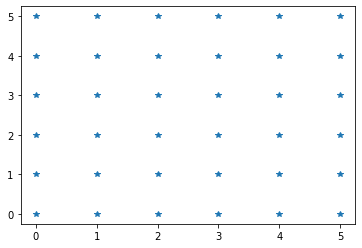

In [13]:
vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],[2, 3],[2, 4],[2, 5],[3, 0],[3, 1],[3, 2],[3, 3],[3, 4],[3, 5],[4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5],[5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]])
plt.plot(vector[:,0], vector[:,1], '*')

In [14]:
df = pd.DataFrame(vector).sort_values(0)
df = df.sort_values(1, ascending=False)
df[0] = [0,1,2,3,4,5]*6
df[2] = list(range(1,len(df)+1))

# Función: enumerar

De los primeros pasos del análisis sísmico es la enumeración de los elementos siguiendo la convención izquierda-derecha, arriba-abajo. Luego como el input son coordenadas no se me hizo intuitiva la enumeración.

In [15]:
def enumerar(vector):
    global horizontal, vertical, NivelHorizontal, NivelVertical
    #print('Horizontal')
    C = 1
    horizontal = []
    for _, esto in sorted(pd.DataFrame(vector).groupby(1), reverse=True):  # to_concat
        if _!=0:
            esto.index.name = "Nivel %d"%_
            esto = esto.sort_values(0)
            esto[2] = [[np.nan]] + [[i, j] for i, j in zip(esto[0].values[:-1], esto[0].values[1:])]
            tmp = [np.nan]
            for i in range(len(esto)-1):
                tmp.append(C)
                C += 1
            esto[3] = tmp
            esto = esto.dropna()
            esto[3] = esto[3].astype(int)
            esto[4] = np.zeros(len(esto))*np.nan
            for _, i in esto.iterrows():
                esto.loc[_, 4] = df[(df[0]==i[0])&(df[1]==i[1])][2].values
            esto[4] = esto[4].astype(int)
            esto[5] = esto[4].values - 1
            esto.columns = ['Xj', 'Yj', 'InicioFin', 'N', 'Nodo j', 'Nodo i']
            #print(esto, '\n')
            horizontal.append(esto)

    NivelHorizontal = np.array([i.index.name for i in horizontal])
    #print('Vertical')

    to_concat = []
    for _, esto in pd.DataFrame(vector).groupby(0):  # Vertical
        esto = esto.sort_values(1)
        esto[4] = [np.nan] + [i for i, j in zip(esto[1].values[:-1], esto[1].values[1:])]
        esto[2] = [np.nan] + [[i, j] for i, j in zip(esto[1].values[:-1], esto[1].values[1:])]
        to_concat.append(esto.dropna())

    vertical = []
    for _, esto in sorted(pd.concat(to_concat).groupby(4), reverse=True):
        del esto[4]
        esto.index.name = "Nivel %d"%_
        esto = esto.sort_values(0)
        tmp = []
        for i in range(len(esto)):
            tmp.append(C)
            C += 1
        esto[3] = tmp
        esto[4] = np.zeros(len(esto))*np.nan
        esto[5] = np.zeros(len(esto))*np.nan
        for _, i in esto.iterrows():
            esto.loc[_, 4] = df[(df[0]==i[0])&(df[1]==i[1])][2].values
            esto.loc[_, 5] = df[(df[0]==i[0])&(df[1]==i[1]-1)][2].values
        esto[4] = esto[4].astype(int)
        esto[5] = esto[5].astype(int)
        esto.columns = ['Xi', 'Yi', 'InicioFin', 'N', 'Nodo i', 'Nodo j']
        #print(esto, '\n')
        vertical.append(esto)
    NivelVertical = np.array([i.index.name for i in vertical])
enumerar(vector)

# Función: aportan_a_nodo

Esta función despues de la enumeración hecha arriba identifica que elementos aportan a qué nodos.

In [16]:
def aportan_a_nodo(Nodo):    
    xjs = [Nodo[0]] + [Nodo[0]+1]
    yis = [Nodo[1]-1] + [Nodo[1]]
    try:
        del ady_horizontal, below_vertical, above_vertical
    except:pass

    try:
        ady_horizontal = horizontal[int(np.array(list(range(len(horizontal))))[NivelHorizontal=='Nivel %d'%Nodo[1]])]
    except:pass

    try:
        above_vertical = vertical[int(np.array(list(range(len(vertical))))[NivelVertical=='Nivel %d'%(Nodo[1])])]
    except:pass
    
    try:
        below_vertical = vertical[int(np.array(list(range(len(vertical))))[NivelVertical=='Nivel %d'%(Nodo[1]-1)])]
        
    except:pass

    aportan = []
    columns = []
    try:
        df_aportan = ady_horizontal[(ady_horizontal['Xj'].values==xjs[0])|(ady_horizontal['Xj'].values==xjs[1])]
        c = 0
        for i, row in df_aportan.iterrows():
            columns.append((['j', df_aportan['N'].values[c]] if Nodo[0]==row['Xj'] else ['i', df_aportan['N'].values[c]]) + [int(df_aportan['Nodo i'].values[c]), int(df_aportan['Nodo j'].values[c])])
            c+=1
        aportan.append(df_aportan)
    except:pass

    try:
        df_aportan = above_vertical[(above_vertical['Xi'].values==Nodo[0])]
        aportan.append(df_aportan)
        columns.append(['j', int(df_aportan['N'].values), int(df_aportan['Nodo i'].values), int(df_aportan['Nodo j'].values)])
        
    except:pass
    
    try:
        df_aportan = below_vertical[(below_vertical['Xi'].values==Nodo[0])]
        aportan.append(df_aportan)
        
        columns.append(['i', int(df_aportan['N'].values), int(df_aportan['Nodo i'].values), int(df_aportan['Nodo j'].values)])
    except:pass
    
    return columns

# Se condensa en una matriz

In [17]:
formulas = []
for i in df.values:
    expresion = ('$P_{%s}$ = '%i[2] + ' + '.join(['$f^{%s}_{%s}$'%(i[1], i[0]) for i in aportan_a_nodo(i[:2])]) 
          + ' = ' + ' + '.join(['$k^{%s}_{%si}U_{%s} + k^{%s}_{%sj}U_{%s}$'%(i[1], i[0], i[2], i[1], i[0], i[3]) 
                                for i in aportan_a_nodo(i[:2])])+'\n')
    #print(expresion)
    formulas.append(expresion)

# Trabajo final

$P_{1}$ = $f^{1}_{i}$ + $f^{26}_{i}$ = $k^{1}_{ii}U_{1} + k^{1}_{ij}U_{2}$ + $k^{26}_{ii}U_{1} + k^{26}_{ij}U_{7}$

$P_{2}$ = $f^{1}_{j}$ + $f^{2}_{i}$ + $f^{27}_{i}$ = $k^{1}_{ji}U_{1} + k^{1}_{jj}U_{2}$ + $k^{2}_{ii}U_{2} + k^{2}_{ij}U_{3}$ + $k^{27}_{ii}U_{2} + k^{27}_{ij}U_{8}$

$P_{3}$ = $f^{2}_{j}$ + $f^{3}_{i}$ + $f^{28}_{i}$ = $k^{2}_{ji}U_{2} + k^{2}_{jj}U_{3}$ + $k^{3}_{ii}U_{3} + k^{3}_{ij}U_{4}$ + $k^{28}_{ii}U_{3} + k^{28}_{ij}U_{9}$

$P_{4}$ = $f^{3}_{j}$ + $f^{4}_{i}$ + $f^{29}_{i}$ = $k^{3}_{ji}U_{3} + k^{3}_{jj}U_{4}$ + $k^{4}_{ii}U_{4} + k^{4}_{ij}U_{5}$ + $k^{29}_{ii}U_{4} + k^{29}_{ij}U_{10}$

$P_{5}$ = $f^{4}_{j}$ + $f^{5}_{i}$ + $f^{30}_{i}$ = $k^{4}_{ji}U_{4} + k^{4}_{jj}U_{5}$ + $k^{5}_{ii}U_{5} + k^{5}_{ij}U_{6}$ + $k^{30}_{ii}U_{5} + k^{30}_{ij}U_{11}$

$P_{6}$ = $f^{5}_{j}$ + $f^{31}_{i}$ = $k^{5}_{ji}U_{5} + k^{5}_{jj}U_{6}$ + $k^{31}_{ii}U_{6} + k^{31}_{ij}U_{12}$

$P_{7}$ = $f^{6}_{i}$ + $f^{26}_{j}$ + $f^{32}_{i}$ = $k^{6}_{ii}U_{7} + k^{6}_{ij}U_{8}$ + $k^{26}_{ji}U_{1} + k^{26}_{jj}U_{7}$ + $k^{32}_{ii}U_{7} + k^{32}_{ij}U_{13}$

$P_{8}$ = $f^{6}_{j}$ + $f^{7}_{i}$ + $f^{27}_{j}$ + $f^{33}_{i}$ = $k^{6}_{ji}U_{7} + k^{6}_{jj}U_{8}$ + $k^{7}_{ii}U_{8} + k^{7}_{ij}U_{9}$ + $k^{27}_{ji}U_{2} + k^{27}_{jj}U_{8}$ + $k^{33}_{ii}U_{8} + k^{33}_{ij}U_{14}$

$P_{9}$ = $f^{7}_{j}$ + $f^{8}_{i}$ + $f^{28}_{j}$ + $f^{34}_{i}$ = $k^{7}_{ji}U_{8} + k^{7}_{jj}U_{9}$ + $k^{8}_{ii}U_{9} + k^{8}_{ij}U_{10}$ + $k^{28}_{ji}U_{3} + k^{28}_{jj}U_{9}$ + $k^{34}_{ii}U_{9} + k^{34}_{ij}U_{15}$

$P_{10}$ = $f^{8}_{j}$ + $f^{9}_{i}$ + $f^{29}_{j}$ + $f^{35}_{i}$ = $k^{8}_{ji}U_{9} + k^{8}_{jj}U_{10}$ + $k^{9}_{ii}U_{10} + k^{9}_{ij}U_{11}$ + $k^{29}_{ji}U_{4} + k^{29}_{jj}U_{10}$ + $k^{35}_{ii}U_{10} + k^{35}_{ij}U_{16}$

$P_{11}$ = $f^{9}_{j}$ + $f^{10}_{i}$ + $f^{30}_{j}$ + $f^{36}_{i}$ = $k^{9}_{ji}U_{10} + k^{9}_{jj}U_{11}$ + $k^{10}_{ii}U_{11} + k^{10}_{ij}U_{12}$ + $k^{30}_{ji}U_{5} + k^{30}_{jj}U_{11}$ + $k^{36}_{ii}U_{11} + k^{36}_{ij}U_{17}$

$P_{12}$ = $f^{10}_{j}$ + $f^{31}_{j}$ + $f^{37}_{i}$ = $k^{10}_{ji}U_{11} + k^{10}_{jj}U_{12}$ + $k^{31}_{ji}U_{6} + k^{31}_{jj}U_{12}$ + $k^{37}_{ii}U_{12} + k^{37}_{ij}U_{18}$

$P_{13}$ = $f^{11}_{i}$ + $f^{32}_{j}$ + $f^{38}_{i}$ = $k^{11}_{ii}U_{13} + k^{11}_{ij}U_{14}$ + $k^{32}_{ji}U_{7} + k^{32}_{jj}U_{13}$ + $k^{38}_{ii}U_{13} + k^{38}_{ij}U_{19}$

$P_{14}$ = $f^{11}_{j}$ + $f^{12}_{i}$ + $f^{33}_{j}$ + $f^{39}_{i}$ = $k^{11}_{ji}U_{13} + k^{11}_{jj}U_{14}$ + $k^{12}_{ii}U_{14} + k^{12}_{ij}U_{15}$ + $k^{33}_{ji}U_{8} + k^{33}_{jj}U_{14}$ + $k^{39}_{ii}U_{14} + k^{39}_{ij}U_{20}$

$P_{15}$ = $f^{12}_{j}$ + $f^{13}_{i}$ + $f^{34}_{j}$ + $f^{40}_{i}$ = $k^{12}_{ji}U_{14} + k^{12}_{jj}U_{15}$ + $k^{13}_{ii}U_{15} + k^{13}_{ij}U_{16}$ + $k^{34}_{ji}U_{9} + k^{34}_{jj}U_{15}$ + $k^{40}_{ii}U_{15} + k^{40}_{ij}U_{21}$

$P_{16}$ = $f^{13}_{j}$ + $f^{14}_{i}$ + $f^{35}_{j}$ + $f^{41}_{i}$ = $k^{13}_{ji}U_{15} + k^{13}_{jj}U_{16}$ + $k^{14}_{ii}U_{16} + k^{14}_{ij}U_{17}$ + $k^{35}_{ji}U_{10} + k^{35}_{jj}U_{16}$ + $k^{41}_{ii}U_{16} + k^{41}_{ij}U_{22}$

$P_{17}$ = $f^{14}_{j}$ + $f^{15}_{i}$ + $f^{36}_{j}$ + $f^{42}_{i}$ = $k^{14}_{ji}U_{16} + k^{14}_{jj}U_{17}$ + $k^{15}_{ii}U_{17} + k^{15}_{ij}U_{18}$ + $k^{36}_{ji}U_{11} + k^{36}_{jj}U_{17}$ + $k^{42}_{ii}U_{17} + k^{42}_{ij}U_{23}$

$P_{18}$ = $f^{15}_{j}$ + $f^{37}_{j}$ + $f^{43}_{i}$ = $k^{15}_{ji}U_{17} + k^{15}_{jj}U_{18}$ + $k^{37}_{ji}U_{12} + k^{37}_{jj}U_{18}$ + $k^{43}_{ii}U_{18} + k^{43}_{ij}U_{24}$

$P_{19}$ = $f^{16}_{i}$ + $f^{38}_{j}$ + $f^{44}_{i}$ = $k^{16}_{ii}U_{19} + k^{16}_{ij}U_{20}$ + $k^{38}_{ji}U_{13} + k^{38}_{jj}U_{19}$ + $k^{44}_{ii}U_{19} + k^{44}_{ij}U_{25}$

$P_{20}$ = $f^{16}_{j}$ + $f^{17}_{i}$ + $f^{39}_{j}$ + $f^{45}_{i}$ = $k^{16}_{ji}U_{19} + k^{16}_{jj}U_{20}$ + $k^{17}_{ii}U_{20} + k^{17}_{ij}U_{21}$ + $k^{39}_{ji}U_{14} + k^{39}_{jj}U_{20}$ + $k^{45}_{ii}U_{20} + k^{45}_{ij}U_{26}$

$P_{21}$ = $f^{17}_{j}$ + $f^{18}_{i}$ + $f^{40}_{j}$ + $f^{46}_{i}$ = $k^{17}_{ji}U_{20} + k^{17}_{jj}U_{21}$ + $k^{18}_{ii}U_{21} + k^{18}_{ij}U_{22}$ + $k^{40}_{ji}U_{15} + k^{40}_{jj}U_{21}$ + $k^{46}_{ii}U_{21} + k^{46}_{ij}U_{27}$

$P_{22}$ = $f^{18}_{j}$ + $f^{19}_{i}$ + $f^{41}_{j}$ + $f^{47}_{i}$ = $k^{18}_{ji}U_{21} + k^{18}_{jj}U_{22}$ + $k^{19}_{ii}U_{22} + k^{19}_{ij}U_{23}$ + $k^{41}_{ji}U_{16} + k^{41}_{jj}U_{22}$ + $k^{47}_{ii}U_{22} + k^{47}_{ij}U_{28}$

$P_{23}$ = $f^{19}_{j}$ + $f^{20}_{i}$ + $f^{42}_{j}$ + $f^{48}_{i}$ = $k^{19}_{ji}U_{22} + k^{19}_{jj}U_{23}$ + $k^{20}_{ii}U_{23} + k^{20}_{ij}U_{24}$ + $k^{42}_{ji}U_{17} + k^{42}_{jj}U_{23}$ + $k^{48}_{ii}U_{23} + k^{48}_{ij}U_{29}$

$P_{24}$ = $f^{20}_{j}$ + $f^{43}_{j}$ + $f^{49}_{i}$ = $k^{20}_{ji}U_{23} + k^{20}_{jj}U_{24}$ + $k^{43}_{ji}U_{18} + k^{43}_{jj}U_{24}$ + $k^{49}_{ii}U_{24} + k^{49}_{ij}U_{30}$

$P_{25}$ = $f^{21}_{i}$ + $f^{44}_{j}$ + $f^{50}_{i}$ = $k^{21}_{ii}U_{25} + k^{21}_{ij}U_{26}$ + $k^{44}_{ji}U_{19} + k^{44}_{jj}U_{25}$ + $k^{50}_{ii}U_{25} + k^{50}_{ij}U_{31}$

$P_{26}$ = $f^{21}_{j}$ + $f^{22}_{i}$ + $f^{45}_{j}$ + $f^{51}_{i}$ = $k^{21}_{ji}U_{25} + k^{21}_{jj}U_{26}$ + $k^{22}_{ii}U_{26} + k^{22}_{ij}U_{27}$ + $k^{45}_{ji}U_{20} + k^{45}_{jj}U_{26}$ + $k^{51}_{ii}U_{26} + k^{51}_{ij}U_{32}$

$P_{27}$ = $f^{22}_{j}$ + $f^{23}_{i}$ + $f^{46}_{j}$ + $f^{52}_{i}$ = $k^{22}_{ji}U_{26} + k^{22}_{jj}U_{27}$ + $k^{23}_{ii}U_{27} + k^{23}_{ij}U_{28}$ + $k^{46}_{ji}U_{21} + k^{46}_{jj}U_{27}$ + $k^{52}_{ii}U_{27} + k^{52}_{ij}U_{33}$

$P_{28}$ = $f^{23}_{j}$ + $f^{24}_{i}$ + $f^{47}_{j}$ + $f^{53}_{i}$ = $k^{23}_{ji}U_{27} + k^{23}_{jj}U_{28}$ + $k^{24}_{ii}U_{28} + k^{24}_{ij}U_{29}$ + $k^{47}_{ji}U_{22} + k^{47}_{jj}U_{28}$ + $k^{53}_{ii}U_{28} + k^{53}_{ij}U_{34}$

$P_{29}$ = $f^{24}_{j}$ + $f^{25}_{i}$ + $f^{48}_{j}$ + $f^{54}_{i}$ = $k^{24}_{ji}U_{28} + k^{24}_{jj}U_{29}$ + $k^{25}_{ii}U_{29} + k^{25}_{ij}U_{30}$ + $k^{48}_{ji}U_{23} + k^{48}_{jj}U_{29}$ + $k^{54}_{ii}U_{29} + k^{54}_{ij}U_{35}$

$P_{30}$ = $f^{25}_{j}$ + $f^{49}_{j}$ + $f^{55}_{i}$ = $k^{25}_{ji}U_{29} + k^{25}_{jj}U_{30}$ + $k^{49}_{ji}U_{24} + k^{49}_{jj}U_{30}$ + $k^{55}_{ii}U_{30} + k^{55}_{ij}U_{36}$

$P_{31}$ = $f^{50}_{j}$ = $k^{50}_{ji}U_{25} + k^{50}_{jj}U_{31}$

$P_{32}$ = $f^{51}_{j}$ = $k^{51}_{ji}U_{26} + k^{51}_{jj}U_{32}$

$P_{33}$ = $f^{52}_{j}$ = $k^{52}_{ji}U_{27} + k^{52}_{jj}U_{33}$

$P_{34}$ = $f^{53}_{j}$ = $k^{53}_{ji}U_{28} + k^{53}_{jj}U_{34}$

$P_{35}$ = $f^{54}_{j}$ = $k^{54}_{ji}U_{29} + k^{54}_{jj}U_{35}$

$P_{36}$ = $f^{55}_{j}$ = $k^{55}_{ji}U_{30} + k^{55}_{jj}U_{36}$

In [14]:
matriz = np.zeros((len(formulas), len(formulas))).tolist()
c = 0
for i in range(len(formulas)):
    for j in range(len(formulas)):
        matriz[i][j] = ' + '.join([r'$'+k.strip(r"'U_{%s}$'"%(j+1))+r'}$' for k in formulas[c].split() if 'U_{%s}'%(j+1) in k])
    c += 1
pd.DataFrame(matriz)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,$k^{1}_{ii}$ + $k^{26}_{ii}$,$k^{1}_{ij}$,,,,,$k^{26}_{ij}$,,,,...,,,,,,,,,,
1,$k^{1}_{ji}$,$k^{1}_{jj}$ + $k^{2}_{ii}$ + $k^{27}_{ii}$,$k^{2}_{ij}$,,,,,$k^{27}_{ij}$,,,...,,,,,,,,,,
2,,$k^{2}_{ji}$,$k^{2}_{jj}$ + $k^{3}_{ii}$ + $k^{28}_{ii}$,$k^{3}_{ij}$,,,,,$k^{28}_{ij}$,,...,,,,,,,,,,
3,,,$k^{3}_{ji}$,$k^{3}_{jj}$ + $k^{4}_{ii}$ + $k^{29}_{ii}$,$k^{4}_{ij}$,,,,,$k^{29}_{ij}$,...,,,,,,,,,,
4,,,,$k^{4}_{ji}$,$k^{4}_{jj}$ + $k^{5}_{ii}$ + $k^{30}_{ii}$,$k^{5}_{ij}$,,,,,...,,,,,,,,,,
5,,,,,$k^{5}_{ji}$,$k^{5}_{jj}$ + $k^{31}_{ii}$,,,,,...,,,,,,,,,,
6,$k^{26}_{ji}$,,,,,,$k^{6}_{ii}$ + $k^{26}_{jj}$ + $k^{32}_{ii}$,$k^{6}_{ij}$,,,...,,,,,,,,,,
7,,$k^{27}_{ji}$,,,,,$k^{6}_{ji}$,$k^{6}_{jj}$ + $k^{7}_{ii}$ + $k^{27}_{jj}$ + ...,$k^{7}_{ij}$,,...,,,,,,,,,,
8,,,$k^{28}_{ji}$,,,,,$k^{7}_{ji}$,$k^{7}_{jj}$ + $k^{8}_{ii}$ + $k^{28}_{jj}$ + ...,$k^{8}_{ij}$,...,,,,,,,,,,
9,,,,$k^{29}_{ji}$,,,,,$k^{8}_{ji}$,$k^{8}_{jj}$ + $k^{9}_{ii}$ + $k^{29}_{jj}$ + ...,...,,,,,,,,,,


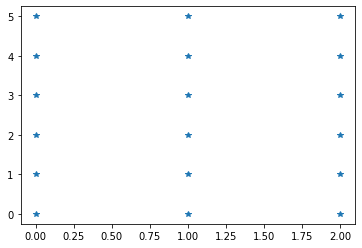

In [18]:
vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],[2, 3],[2, 4],[2, 5]])
plt.plot(vector[:,0], vector[:,1], '*')

In [19]:
df = pd.DataFrame(vector).sort_values(0)
df = df.sort_values(1, ascending=False)
df[0] = [0,1,2]*6
df[2] = list(range(1,len(df)+1))
enumerar(vector)

In [20]:
formulas = []
for i in df.values:
    expresion = ('$P_{%s}$ = '%i[2] + ' + '.join(['$f^{%s}_{%s}$'%(i[1], i[0]) for i in aportan_a_nodo(i[:2])]) 
          + ' = ' + ' + '.join(['$k^{%s}_{%si}U_{%s} + k^{%s}_{%sj}U_{%s}$'%(i[1], i[0], i[2], i[1], i[0], i[3]) 
                                for i in aportan_a_nodo(i[:2])])+'\n')
    #print(expresion)
    formulas.append(expresion)

# Trabajo final 
$P_{1}$ = $f^{1}_{i}$ + $f^{11}_{i}$ = $k^{1}_{ii}U_{1} + k^{1}_{ij}U_{2}$ + $k^{11}_{ii}U_{1} + k^{11}_{ij}U_{4}$

$P_{2}$ = $f^{1}_{j}$ + $f^{2}_{i}$ + $f^{12}_{i}$ = $k^{1}_{ji}U_{1} + k^{1}_{jj}U_{2}$ + $k^{2}_{ii}U_{2} + k^{2}_{ij}U_{3}$ + $k^{12}_{ii}U_{2} + k^{12}_{ij}U_{5}$

$P_{3}$ = $f^{2}_{j}$ + $f^{13}_{i}$ = $k^{2}_{ji}U_{2} + k^{2}_{jj}U_{3}$ + $k^{13}_{ii}U_{3} + k^{13}_{ij}U_{6}$

$P_{4}$ = $f^{3}_{i}$ + $f^{11}_{j}$ + $f^{14}_{i}$ = $k^{3}_{ii}U_{4} + k^{3}_{ij}U_{5}$ + $k^{11}_{ji}U_{1} + k^{11}_{jj}U_{4}$ + $k^{14}_{ii}U_{4} + k^{14}_{ij}U_{7}$

$P_{5}$ = $f^{3}_{j}$ + $f^{4}_{i}$ + $f^{12}_{j}$ + $f^{15}_{i}$ = $k^{3}_{ji}U_{4} + k^{3}_{jj}U_{5}$ + $k^{4}_{ii}U_{5} + k^{4}_{ij}U_{6}$ + $k^{12}_{ji}U_{2} + k^{12}_{jj}U_{5}$ + $k^{15}_{ii}U_{5} + k^{15}_{ij}U_{8}$

$P_{6}$ = $f^{4}_{j}$ + $f^{13}_{j}$ + $f^{16}_{i}$ = $k^{4}_{ji}U_{5} + k^{4}_{jj}U_{6}$ + $k^{13}_{ji}U_{3} + k^{13}_{jj}U_{6}$ + $k^{16}_{ii}U_{6} + k^{16}_{ij}U_{9}$

$P_{7}$ = $f^{5}_{i}$ + $f^{14}_{j}$ + $f^{17}_{i}$ = $k^{5}_{ii}U_{7} + k^{5}_{ij}U_{8}$ + $k^{14}_{ji}U_{4} + k^{14}_{jj}U_{7}$ + $k^{17}_{ii}U_{7} + k^{17}_{ij}U_{10}$

$P_{8}$ = $f^{5}_{j}$ + $f^{6}_{i}$ + $f^{15}_{j}$ + $f^{18}_{i}$ = $k^{5}_{ji}U_{7} + k^{5}_{jj}U_{8}$ + $k^{6}_{ii}U_{8} + k^{6}_{ij}U_{9}$ + $k^{15}_{ji}U_{5} + k^{15}_{jj}U_{8}$ + $k^{18}_{ii}U_{8} + k^{18}_{ij}U_{11}$

$P_{9}$ = $f^{6}_{j}$ + $f^{16}_{j}$ + $f^{19}_{i}$ = $k^{6}_{ji}U_{8} + k^{6}_{jj}U_{9}$ + $k^{16}_{ji}U_{6} + k^{16}_{jj}U_{9}$ + $k^{19}_{ii}U_{9} + k^{19}_{ij}U_{12}$

$P_{10}$ = $f^{7}_{i}$ + $f^{17}_{j}$ + $f^{20}_{i}$ = $k^{7}_{ii}U_{10} + k^{7}_{ij}U_{11}$ + $k^{17}_{ji}U_{7} + k^{17}_{jj}U_{10}$ + $k^{20}_{ii}U_{10} + k^{20}_{ij}U_{13}$

$P_{11}$ = $f^{7}_{j}$ + $f^{8}_{i}$ + $f^{18}_{j}$ + $f^{21}_{i}$ = $k^{7}_{ji}U_{10} + k^{7}_{jj}U_{11}$ + $k^{8}_{ii}U_{11} + k^{8}_{ij}U_{12}$ + $k^{18}_{ji}U_{8} + k^{18}_{jj}U_{11}$ + $k^{21}_{ii}U_{11} + k^{21}_{ij}U_{14}$

$P_{12}$ = $f^{8}_{j}$ + $f^{19}_{j}$ + $f^{22}_{i}$ = $k^{8}_{ji}U_{11} + k^{8}_{jj}U_{12}$ + $k^{19}_{ji}U_{9} + k^{19}_{jj}U_{12}$ + $k^{22}_{ii}U_{12} + k^{22}_{ij}U_{15}$

$P_{13}$ = $f^{9}_{i}$ + $f^{20}_{j}$ + $f^{23}_{i}$ = $k^{9}_{ii}U_{13} + k^{9}_{ij}U_{14}$ + $k^{20}_{ji}U_{10} + k^{20}_{jj}U_{13}$ + $k^{23}_{ii}U_{13} + k^{23}_{ij}U_{16}$

$P_{14}$ = $f^{9}_{j}$ + $f^{10}_{i}$ + $f^{21}_{j}$ + $f^{24}_{i}$ = $k^{9}_{ji}U_{13} + k^{9}_{jj}U_{14}$ + $k^{10}_{ii}U_{14} + k^{10}_{ij}U_{15}$ + $k^{21}_{ji}U_{11} + k^{21}_{jj}U_{14}$ + $k^{24}_{ii}U_{14} + k^{24}_{ij}U_{17}$

$P_{15}$ = $f^{10}_{j}$ + $f^{22}_{j}$ + $f^{25}_{i}$ = $k^{10}_{ji}U_{14} + k^{10}_{jj}U_{15}$ + $k^{22}_{ji}U_{12} + k^{22}_{jj}U_{15}$ + $k^{25}_{ii}U_{15} + k^{25}_{ij}U_{18}$

$P_{16}$ = $f^{23}_{j}$ = $k^{23}_{ji}U_{13} + k^{23}_{jj}U_{16}$

$P_{17}$ = $f^{24}_{j}$ = $k^{24}_{ji}U_{14} + k^{24}_{jj}U_{17}$

$P_{18}$ = $f^{25}_{j}$ = $k^{25}_{ji}U_{15} + k^{25}_{jj}U_{18}$

In [21]:
matriz = np.zeros((len(formulas), len(formulas))).tolist()
c = 0
for i in range(len(formulas)):
    for j in range(len(formulas)):
        matriz[i][j] = ' + '.join([r'$'+k.strip(r"'U_{%s}$'"%(j+1))+r'}$' for k in formulas[c].split() if 'U_{%s}'%(j+1) in k])
    c += 1
pd.DataFrame(matriz)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,$k^{1}_{ii}$ + $k^{11}_{ii}$,$k^{1}_{ij}$,,$k^{11}_{ij}$,,,,,,,,,,,,,,
1,$k^{1}_{ji}$,$k^{1}_{jj}$ + $k^{2}_{ii}$ + $k^{12}_{ii}$,$k^{2}_{ij}$,,$k^{12}_{ij}$,,,,,,,,,,,,,
2,,$k^{2}_{ji}$,$k^{2}_{jj}$ + $k^{13}_{ii}$,,,$k^{13}_{ij}$,,,,,,,,,,,,
3,$k^{11}_{ji}$,,,$k^{3}_{ii}$ + $k^{11}_{jj}$ + $k^{14}_{ii}$,$k^{3}_{ij}$,,$k^{14}_{ij}$,,,,,,,,,,,
4,,$k^{12}_{ji}$,,$k^{3}_{ji}$,$k^{3}_{jj}$ + $k^{4}_{ii}$ + $k^{12}_{jj}$ + ...,$k^{4}_{ij}$,,$k^{15}_{ij}$,,,,,,,,,,
5,,,$k^{13}_{ji}$,,$k^{4}_{ji}$,$k^{4}_{jj}$ + $k^{13}_{jj}$ + $k^{16}_{ii}$,,,$k^{16}_{ij}$,,,,,,,,,
6,,,,$k^{14}_{ji}$,,,$k^{5}_{ii}$ + $k^{14}_{jj}$ + $k^{17}_{ii}$,$k^{5}_{ij}$,,$k^{17}_{ij}$,,,,,,,,
7,,,,,$k^{15}_{ji}$,,$k^{5}_{ji}$,$k^{5}_{jj}$ + $k^{6}_{ii}$ + $k^{15}_{jj}$ + ...,$k^{6}_{ij}$,,$k^{18}_{ij}$,,,,,,,
8,,,,,,$k^{16}_{ji}$,,$k^{6}_{ji}$,$k^{6}_{jj}$ + $k^{16}_{jj}$ + $k^{19}_{ii}$,,,$k^{19}_{ij}$,,,,,,
9,,,,,,,$k^{17}_{ji}$,,,$k^{7}_{ii}$ + $k^{17}_{jj}$ + $k^{20}_{ii}$,$k^{7}_{ij}$,,$k^{20}_{ij}$,,,,,


# Ejemplo del cuaderno

$P_{1}$ = $f^{1}_{i}$ + $f^{4}_{i}$ = $k^{1}_{ii}U_1 + k^{1}_{ij}U_2$ + $k^{4}_{ii}U_1 + k^{4}_{ij}U_3$

$P_{2}$ = $f^{1}_{j}$ + $f^{5}_{i}$ = $k^{1}_{ji}U_1 + k^{1}_{jj}U_2$ + $k^{5}_{ii}U_2 + k^{5}_{ij}U_4$

$P_{3}$ = $f^{2}_{i}$ + $f^{6}_{i}$ + $f^{4}_{j}$ = $k^{2}_{ii}U_3 + k^{2}_{ij}U_4$ + $k^{6}_{ii}U_3 + k^{6}_{ij}U_6$ + $k^{4}_{ji}U_1 + k^{4}_{jj}U_3$

$P_{4}$ = $f^{2}_{j}$ + $f^{3}_{i}$ + $f^{7}_{i}$ + $f^{5}_{j}$ = $k^{2}_{ji}U_3 + k^{2}_{jj}U_4$ + $k^{3}_{ii}U_4 + k^{3}_{ij}U_5$ + $k^{7}_{ii}U_4 + k^{7}_{ij}U_7$ + $k^{5}_{ji}U_2 + k^{5}_{jj}U_4$

$P_{5}$ = $f^{3}_{j}$ + $f^{8}_{i}$ = $k^{3}_{ji}U_4 + k^{3}_{jj}U_5$ + $k^{8}_{ii}U_5 + k^{8}_{ij}U_8$

$P_{6}$ = $f^{6}_{j}$ = $k^{6}_{ji}U_3 + k^{6}_{jj}U_6$

$P_{7}$ = $f^{7}_{j}$ = $k^{7}_{ji}U_4 + k^{7}_{jj}U_7$

$P_{8}$ = $f^{8}_{j}$ = $k^{8}_{ji}U_5 + k^{8}_{jj}U_8$